In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms.v2 as T
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
make_pil = T.ToPILImage()

train_data = torchvision.datasets.ImageFolder(
    "../data/resized/train",
    transform=T.Compose([
        # T.Resize((64, 64)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)
val_data = torchvision.datasets.ImageFolder(
    "../data/resized/test",
    transform=T.Compose([
        # T.Resize((64, 64)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2, persistent_workers=True)

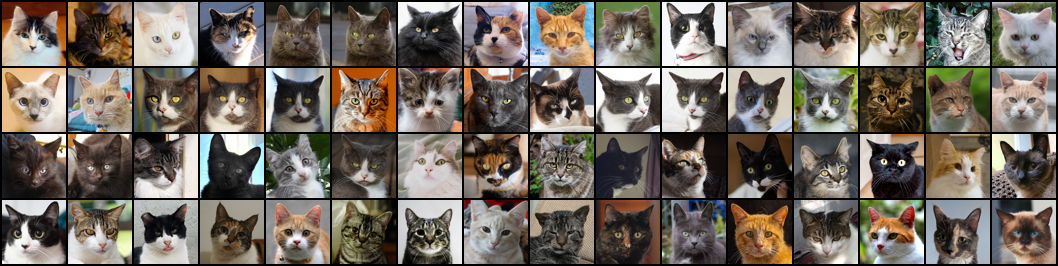

In [3]:
x, _ = next(iter(val_loader))
make_pil(torchvision.utils.make_grid(x, nrow=16))

In [22]:
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, m=4):
        super().__init__()
        self.norm1 = nn.GroupNorm(in_channels, in_channels)
        self.norm2 = nn.GroupNorm(out_channels, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
        self.skip = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self, x):
        residual = x
        
        x = self.norm1(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.norm2(x)
        x = self.conv2(x)
        x = F.gelu(x)
        
        return x + self.skip(residual)

class AttnBlock(nn.Module):
    def __init__(self, in_channels, num_heads):
        super().__init__()
        self.in_channels = in_channels

        self.attn = nn.MultiheadAttention(in_channels, num_heads, dropout=0, add_bias_kv=False, batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, W, H = x.shape
        x = rearrange(x, "b c h w -> b (h w) c")
        x = x + self.attn(x, x, x, need_weights=False)[0]
        x = rearrange(x, "b (h w) c -> b c h w", b=B, c=C, w=W, h=H)
        return x

class DiagonalGaussian(nn.Module):
    def __init__(self, sample: bool = True, chunk_dim: int = 1):
        super().__init__()
        self.sample = sample
        self.chunk_dim = chunk_dim

    def forward(self, mean, logvar) -> torch.Tensor:
        if self.sample:
            std = torch.exp(0.5 * logvar)
            return mean + std * torch.randn_like(mean)
        else:
            return mean

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Residual(3, 16),
            nn.MaxPool2d(2),
            Residual(16, 32),
            nn.MaxPool2d(2),
            Residual(32, 64),
            Residual(64, 64),
            Residual(64, 64),
            # AttnBlock(64, 16),
            # AttnBlock(64, 16),
            nn.MaxPool2d(2),
            Residual(64, 8 * 2),
        )
        
        self.decoder = nn.Sequential(
            Residual(8, 64),
            nn.Upsample(scale_factor=2),
            # AttnBlock(64, 16),
            # AttnBlock(64, 16),
            Residual(64, 32),
            Residual(32, 32),
            Residual(32, 32),
            nn.Upsample(scale_factor=2),
            Residual(32, 16),
            nn.Upsample(scale_factor=2),
            Residual(16, 3),
            nn.Sigmoid(),
        )
        self.reg = DiagonalGaussian()
        
    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    @staticmethod
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reg(mu, logvar)
        
        x = self.decoder(z)
        return x, mu, logvar
    
model = Model()
print(summary(model, (64, 3, 64, 64), depth=2))
# model = torch.jit.script(model)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3, 64, 64]           --
├─Sequential: 1-1                        [64, 16, 8, 8]            --
│    └─Residual: 2-1                     [64, 16, 64, 64]          2,870
│    └─MaxPool2d: 2-2                    [64, 16, 32, 32]          --
│    └─Residual: 2-3                     [64, 32, 32, 32]          14,528
│    └─MaxPool2d: 2-4                    [64, 32, 16, 16]          --
│    └─Residual: 2-5                     [64, 64, 16, 16]          57,728
│    └─Residual: 2-6                     [64, 64, 16, 16]          78,272
│    └─Residual: 2-7                     [64, 64, 16, 16]          78,272
│    └─MaxPool2d: 2-8                    [64, 64, 8, 8]            --
│    └─Residual: 2-9                     [64, 16, 8, 8]            12,752
├─DiagonalGaussian: 1-2                  [64, 8, 8, 8]             --
├─Sequential: 1-3                        [64, 3, 64, 64]      

In [23]:
model.to("mps")
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=5e-4)

In [24]:
for epoch in range(8):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for x, _ in pbar:
        optimizer.zero_grad()
        x = x.to("mps")
        x_hat, mu, logvar = model(x)
        recon_loss = F.binary_cross_entropy(x_hat, x)
        kl = Model.kl_loss(mu, logvar).mean() / x.shape.numel()
        
        loss = recon_loss + kl

        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f"loss={loss.item():.4f}, psnr={10 * torch.log10(1 / F.mse_loss(x, x_hat)).item():.4f}, recon_loss={recon_loss:.4f}, kl={kl:.4f}")
        
    model.eval()
    total_loss = 0
    total_psnr = 0
    
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to("mps")
            x_hat, mu, logvar = model(x)
            recon_loss = F.binary_cross_entropy(x_hat, x)
            kl = Model.kl_loss(mu, logvar).mean() / x.shape.numel()
            
            loss = recon_loss + kl

            total_loss += loss.item()
            total_psnr += 10 * torch.log10(1 / F.mse_loss(x, x_hat)).item()
            
    total_loss /= len(val_loader)
    total_psnr /= len(val_loader)    

Epoch 5:  22%|██▏       | 50/224 [00:03<00:13, 12.92it/s, loss=0.6010, psnr=18.4791, recon_loss=0.5895, kl=0.0115]


KeyboardInterrupt: 

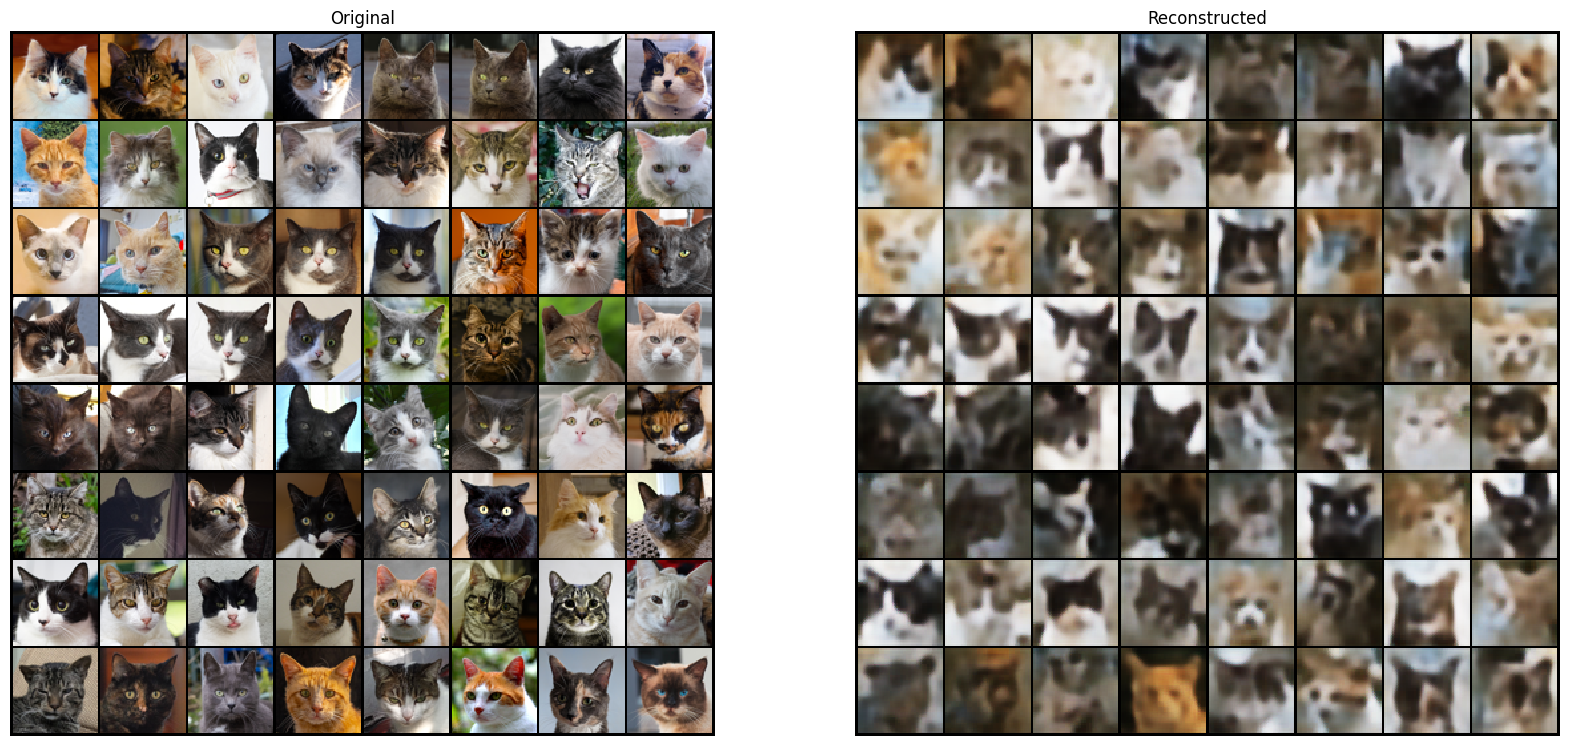

In [26]:
# reconstruct images
model.eval()
x, _ = next(iter(val_loader))
x = x.to("mps")
x_hat, mu, logvar = model(x)
x_hat = x_hat.to("cpu").detach()
x = x.to("cpu")
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(x, nrow=8).permute(1, 2, 0), interpolation="nearest")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0), interpolation="nearest")
plt.axis("off")
plt.title("Reconstructed")
plt.show()

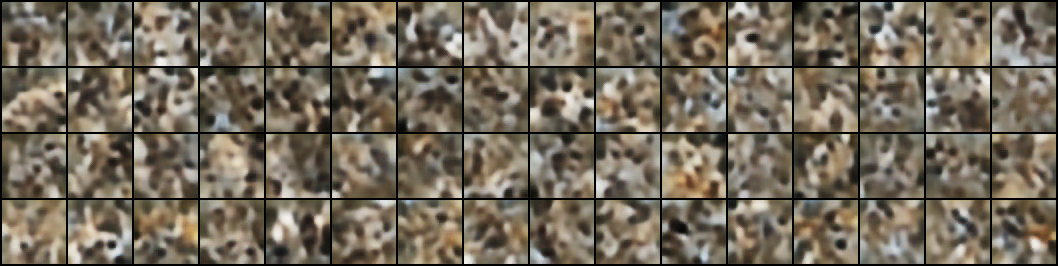

In [21]:
make_pil(torchvision.utils.make_grid(model.decoder(torch.randn_like(mu, device="mps")), nrow=16))